In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob 
import keras
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import skimage.color as scc

from skimage import io
from random import randint
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ID
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [139]:
conda install keras

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.



EnvironmentLocationNotFound: Not a conda environment: C:\Users\Sriya



In [134]:
pip install np_utils

     ---------------------------------------- 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56454 sha256=93e3ed86a17c61397616d22db8edebcb7a0d1e901588f9333a9a250742ef5c5e
  Stored in directory: c:\users\sriya nukala\appdata\local\pip\cache\wheels\c9\5e\52\216e2fa9b02d46b865d8160e7fe29dcf98f89a2fb7be254877
Successfully built np_utils
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install tensorflow

     -------------------------------------- 284.1/284.1 MB 2.9 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 4.9 MB/s eta 0:00:00
     ------------------------------------- 182.0/182.0 kB 10.7 MB/s eta 0:00:00
     -------------------------------------- 151.

In [2]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
dataset_path = r'C:\Users\Sriya Nukala\Downloads\Dataset1\gaussian_filtered_images'
filepaths=[]
labels=[]

In [5]:
folds = os.listdir(dataset_path)

In [6]:
folds

['export.pkl', 'Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [7]:
for fold in folds:
    foldpath = os.path.join(dataset_path, fold)  
    # skip export.pkl file
    if pathlib.Path(foldpath).suffix == '':
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

In [8]:
img_paths = pd.Series(filepaths, name= 'filepaths')
img_labels = pd.Series(labels, name='labels')
dataset = pd.concat([img_paths, img_labels], axis= 1)

In [9]:
dataset

filepaths  labels
0     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
1     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
2     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
3     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
4     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
...                                                 ...     ...
3657  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3658  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3659  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3660  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3661  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe

[3662 rows x 2 columns]

In [10]:
batch_size=3662
img=224
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

gen=ID()
data_gen = gen.flow_from_dataframe( dataset,x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


Found 3662 validated image filenames belonging to 5 classes.


In [11]:
img_data, img_labels = data_gen.next()

In [12]:
print(img_data.shape, img_labels.shape)

(3662, 224, 224, 3) (3662, 5)


In [13]:
img_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

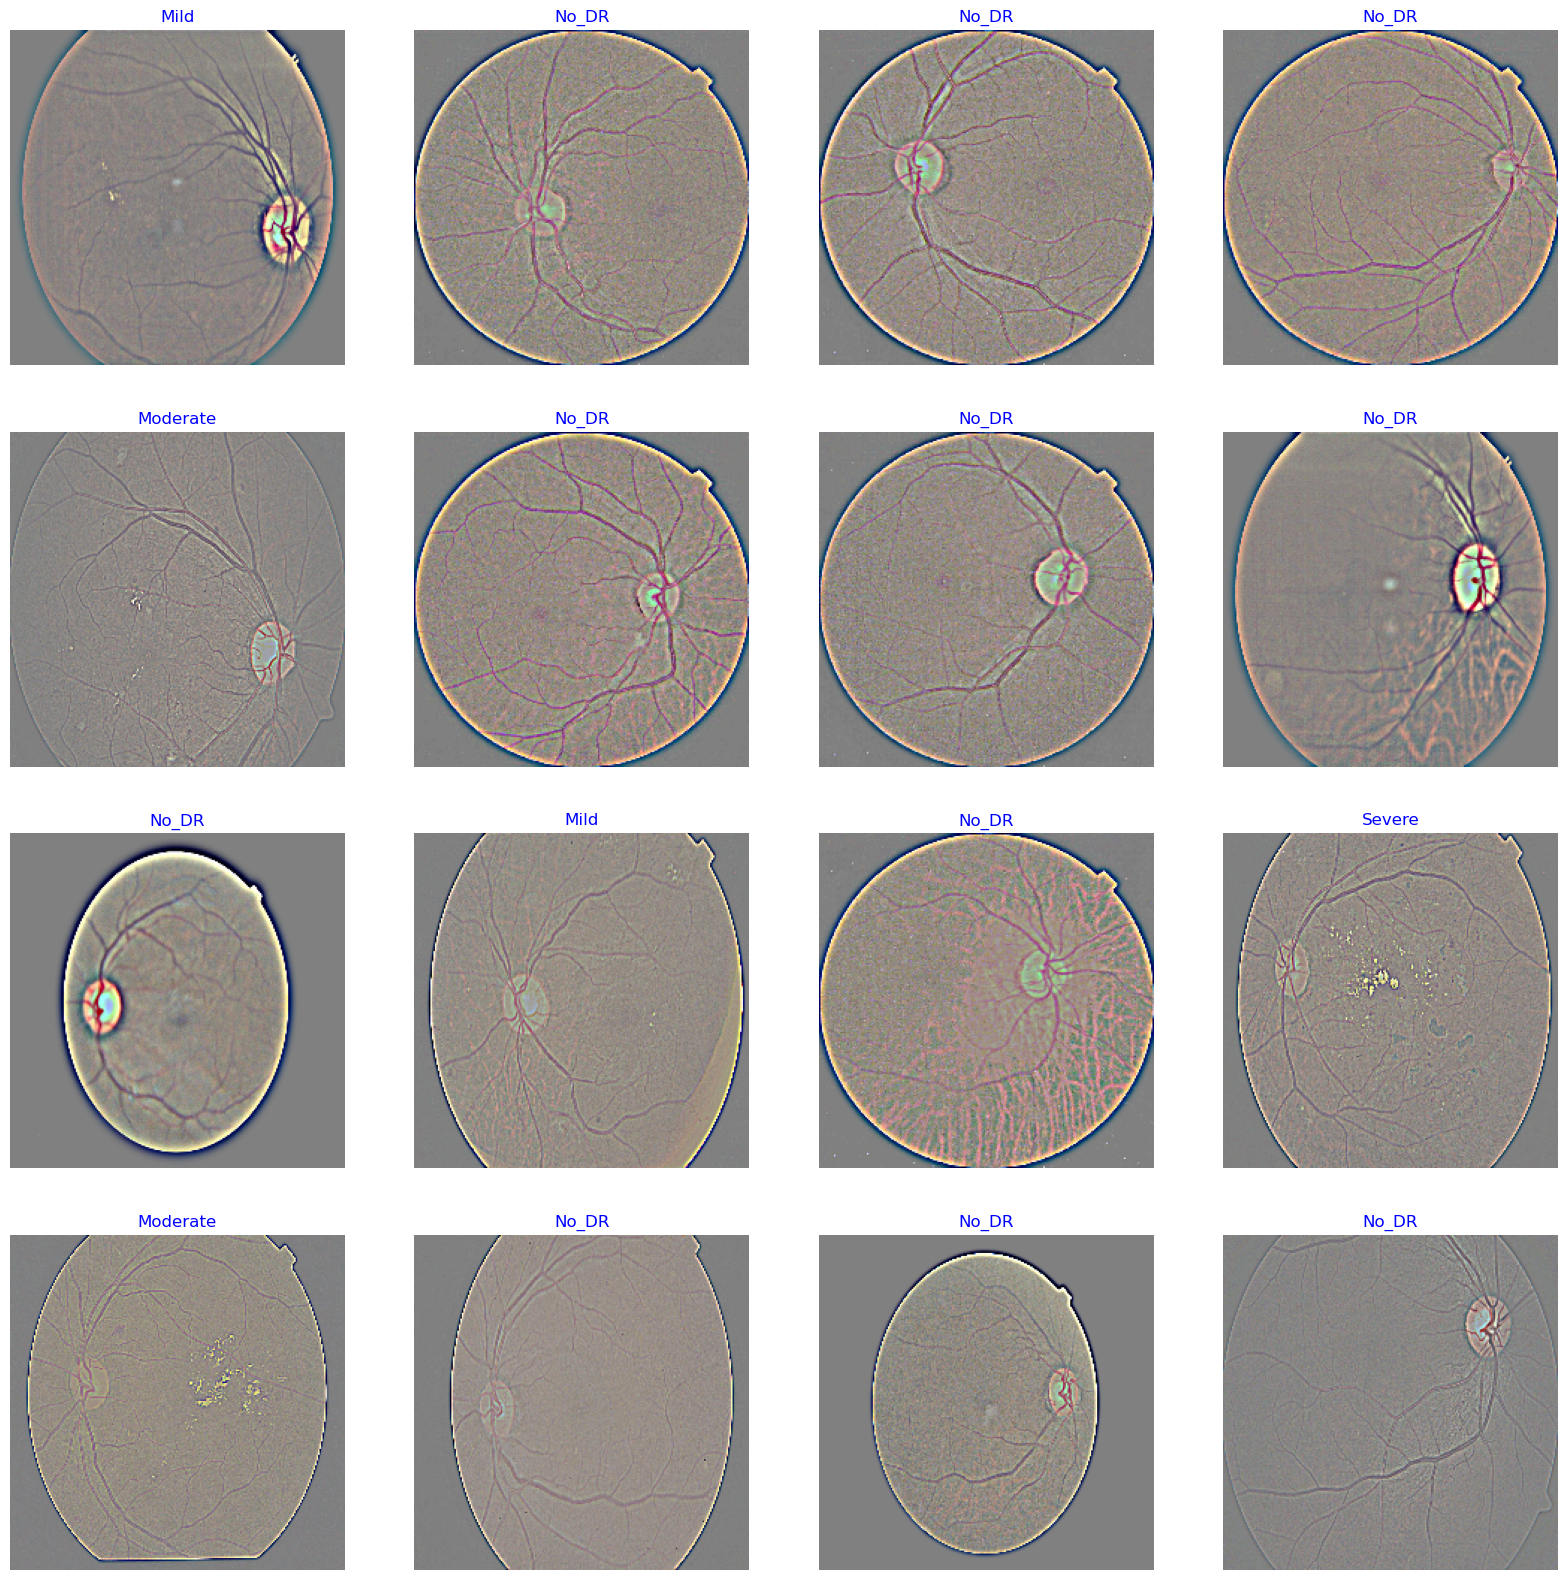

In [14]:
g_dict = data_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(data_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(img_data, img_labels, test_size = 0.25, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [16]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = img_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

C:\Users\Sriya Nukala\anaconda3\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [17]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [19]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [20]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = METRICS)

In [21]:
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)


In [23]:
model.fit(train_data,train_labels,
          validation_data= (val_data,val_labels),
          epochs = 10,
          batch_size=32,
          callbacks = early_stopping_callbacks)

Epoch 1/10
69/69 [==============================] - 1148s 17s/step - loss: 1.4208 - Accuracy: 0.5059 - AUC: 0.7740 - f1_score: 0.3284 - val_loss: 1.4623 - val_Accuracy: 0.5182 - val_AUC: 0.7377 - val_f1_score: 0.2663
Epoch 2/10
69/69 [==============================] - 1164s 17s/step - loss: 1.2210 - Accuracy: 0.6457 - AUC: 0.8769 - f1_score: 0.3954 - val_loss: 1.2840 - val_Accuracy: 0.5927 - val_AUC: 0.8384 - val_f1_score: 0.3295
Epoch 3/10
69/69 [==============================] - 1400s 20s/step - loss: 1.1669 - Accuracy: 0.6794 - AUC: 0.8983 - f1_score: 0.4070 - val_loss: 1.2410 - val_Accuracy: 0.6527 - val_AUC: 0.8699 - val_f1_score: 0.3129
Epoch 4/10
69/69 [==============================] - 1238s 18s/step - loss: 1.1319 - Accuracy: 0.7113 - AUC: 0.9119 - f1_score: 0.4338 - val_loss: 1.2341 - val_Accuracy: 0.6509 - val_AUC: 0.8699 - val_f1_score: 0.3877
Epoch 5/10
69/69 [==============================] - 1185s 17s/step - loss: 1.1052 - Accuracy: 0.7263 - AUC: 0.9220 - f1_score: 0.441

In [24]:
train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data,test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

29/29 [==============================] - 136s 5s/step - loss: 1.1809 - Accuracy: 0.6878 - AUC: 0.8994 - f1_score: 0.4075
Training Accuracy: 77.23%
Validation Accuracy: 68.36%
Testing Accuracy: 68.78%


In [16]:
# sm = SMOTE(random_state=42)

# train_data1, train_labels1 = sm.fit_resample(train_data.reshape(-1, img * img * 3), train_labels)

# train_data2 = train_data1.reshape(-1, img, img, 3)

# print(train_data2.shape, train_labels1.shape)

(5435, 224, 224, 3) (5435, 5)


In [17]:
# test_data1, test_labels1 = sm.fit_resample(test_data.reshape(-1, img * img * 3), test_labels)

# test_data2 = test_data1.reshape(-1, img, img, 3)

# print(test_data2.shape, test_labels1.shape)

(2285, 224, 224, 3) (2285, 5)


In [18]:
# val_data1, val_labels1 = sm.fit_resample(val_data.reshape(-1, img * img * 3), val_labels)

# val_data2 = val_data1.reshape(-1, img, img, 3)

# print(val_data2.shape, val_labels1.shape)

(1305, 224, 224, 3) (1305, 5)


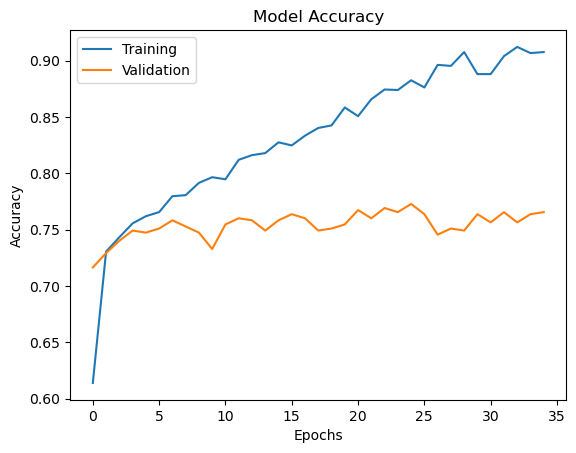

In [24]:
fig, ax = plt.subplots()
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Accuracy_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

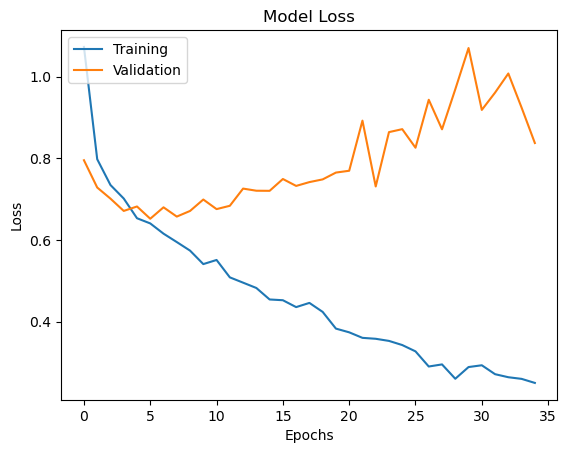

In [25]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Loss_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

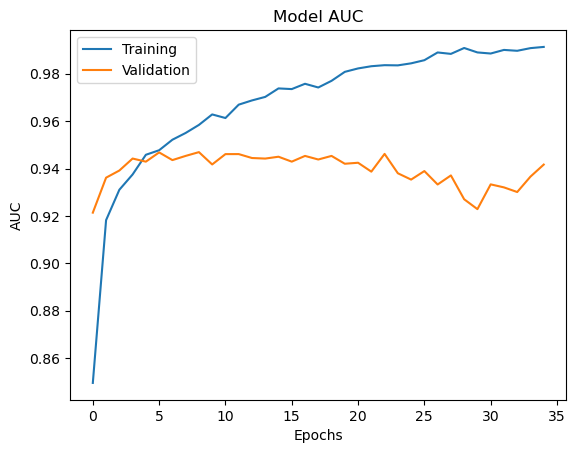

In [26]:
fig, ax = plt.subplots()
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model AUC_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

In [27]:
pred_labels = model.predict(test_data)

29/29 [==============================] - 50s 2s/step


In [28]:
from sklearn import metrics
auc = metrics.roc_auc_score(test_labels,pred_labels,multi_class='ovo')
auc

0.9196532345134594

In [29]:
auc

0.9196532345134594

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
conf_arr

array([[ 49,  34,  10,   5,   0],
       [ 14, 198,  11,  15,   6],
       [ 10,   6, 446,   0,   0],
       [  6,  29,   1,  30,   6],
       [  1,  29,   0,   4,   6]], dtype=int64)

In [32]:
CLASSES=['No_DR','Mild','Moderate','Severe','Proliferate_DR']

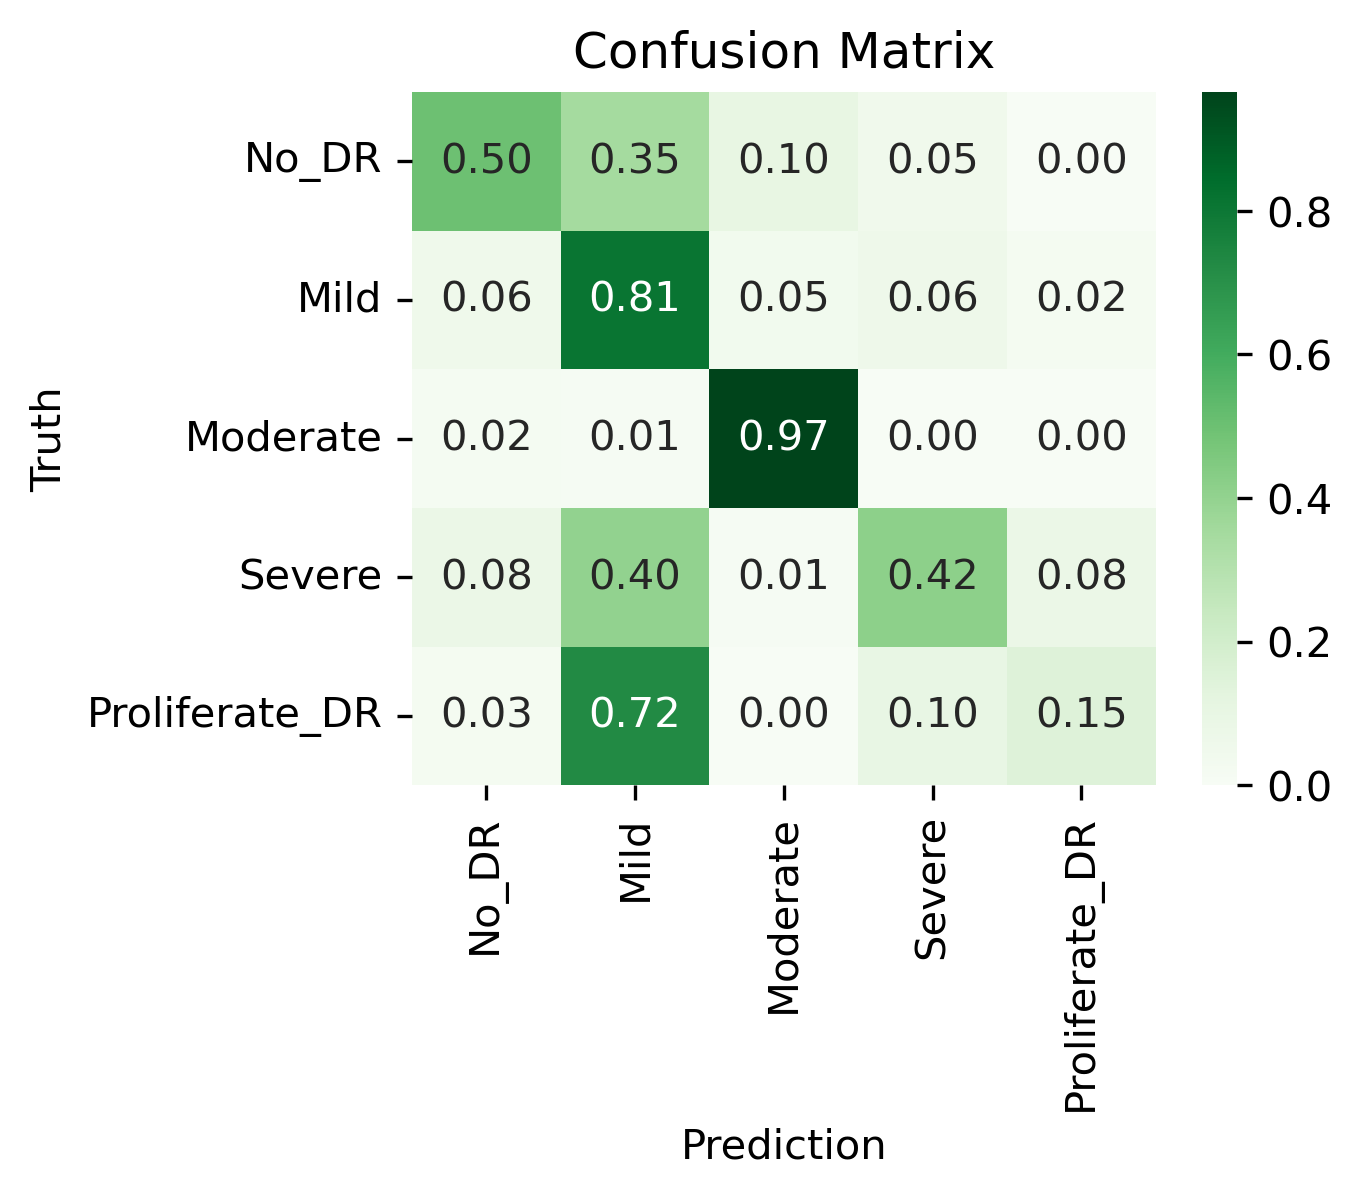

In [33]:
# pred_ls = np.argmax(pred_labels, axis=1)
# test_ls = np.argmax(test_labels, axis=1)

# conf_arr = confusion_matrix(test_ls, pred_ls)
cmn = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis]
fig=plt.figure(figsize=(4,3), dpi=300, facecolor='w', edgecolor='k')

ax = sns.heatmap(cmn, cmap='Greens', annot=True, fmt=".2f", xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
ax.figure.savefig('confmatrix_ENETB3-79.5.png', format='png', dpi=300)

In [34]:
pred_labels1=np.argmax(pred_labels,axis=1)
test_labels1=np.argmax(test_labels,axis=1)

In [35]:
from sklearn.preprocessing import label_binarize

In [36]:
predlabels_new=label_binarize(pred_labels1,classes=np.unique(pred_labels1))
classes=np.unique(pred_labels1)

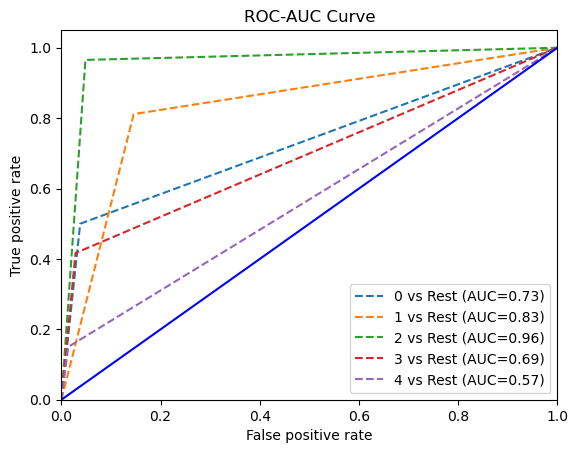

In [37]:
fig, ax = plt.subplots()
f_p_r=dict()
t_p_r = dict()
thres=dict()
rocauc_curve= dict()
total_no_of_class = classes.shape[0]
for i in range(total_no_of_class):    
    f_p_r[i], t_p_r[i], thres[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    rocauc_curve[i] = metrics.auc(f_p_r[i], t_p_r[i])    
    plt.plot(f_p_r[i], t_p_r[i], linestyle='--',label='%s vs Rest (AUC=%0.2f)'%(classes[i],rocauc_curve[i]))

plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC-AUC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('ROCAUC_EfficientNetB3-79.5.png', format='png', dpi=300)

In [38]:
from sklearn.metrics import classification_report

In [39]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                precision    recall  f1-score   support

         No_DR       0.61      0.50      0.55        98
          Mild       0.67      0.81      0.73       244
      Moderate       0.95      0.97      0.96       462
        Severe       0.56      0.42      0.48        72
Proliferate_DR       0.33      0.15      0.21        40

     micro avg       0.80      0.80      0.80       916
     macro avg       0.62      0.57      0.59       916
  weighted avg       0.78      0.80      0.78       916
   samples avg       0.80      0.80      0.80       916



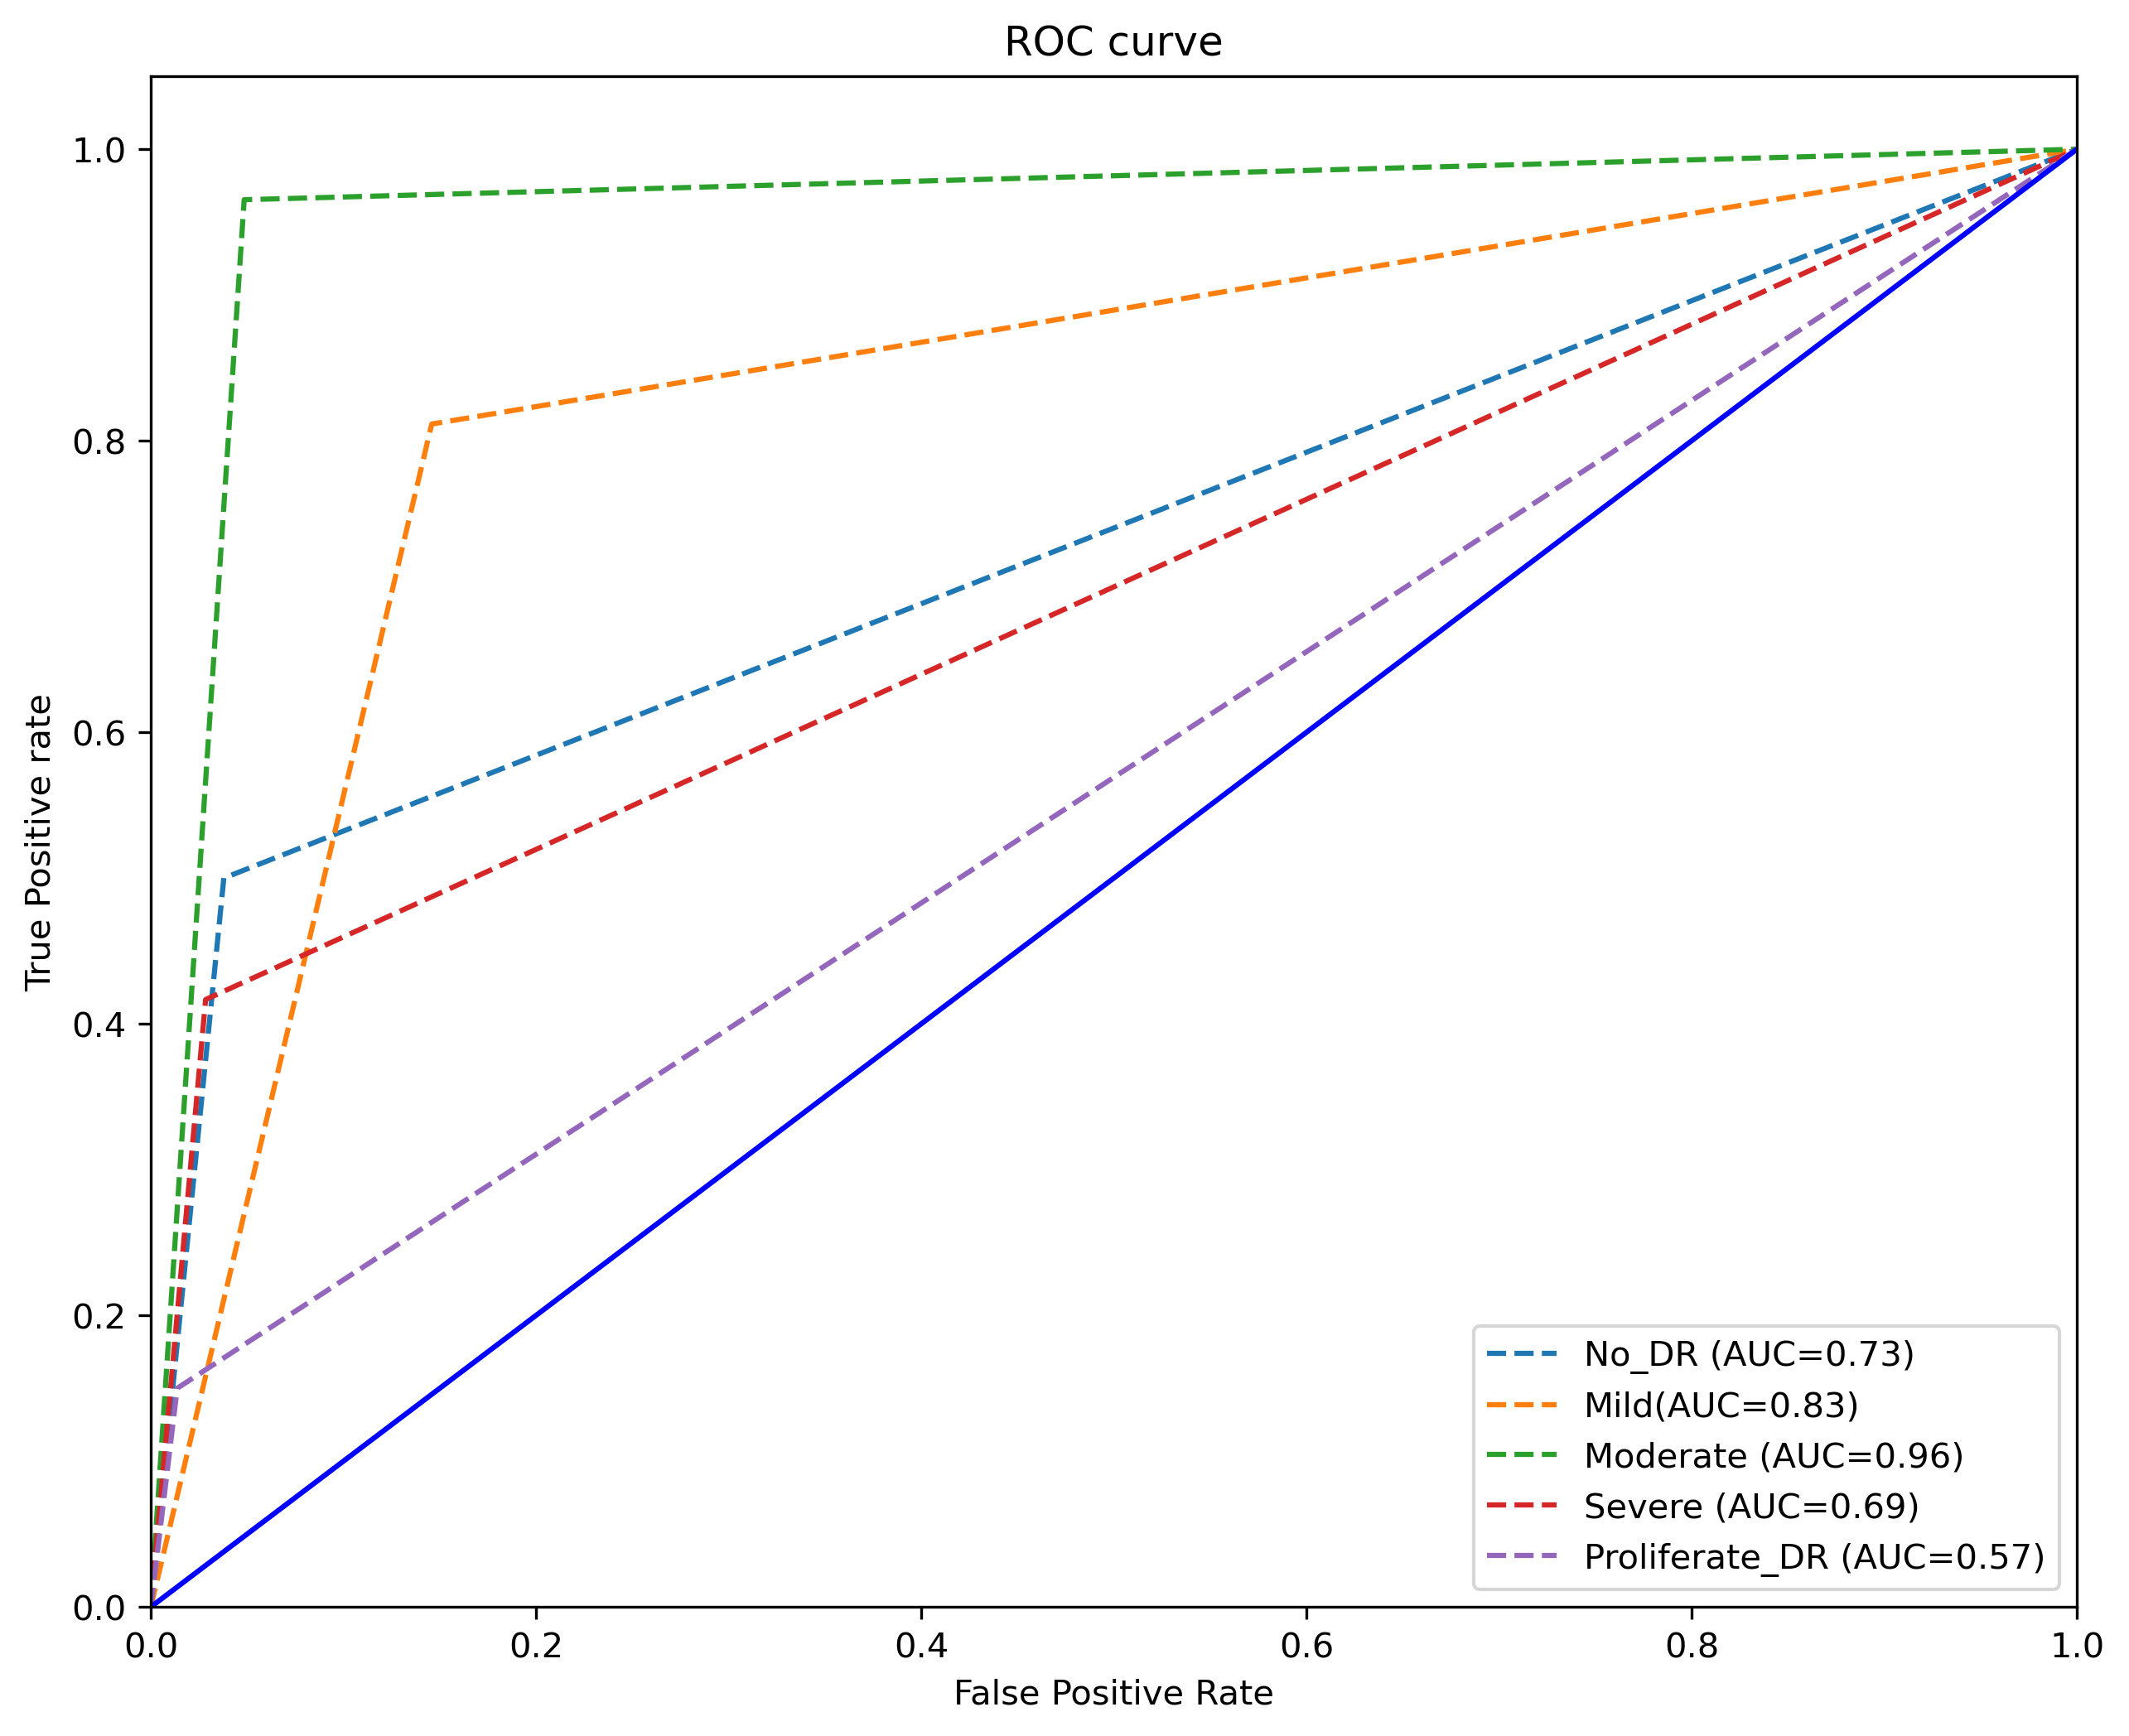

In [43]:
pr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]
fig=plt.figure(figsize=(10, 8), dpi=300)
for i, in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='No_DR (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Mild(AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Moderate (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Severe (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==4:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Proliferate_DR (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet-79_5.png',dpi=300)

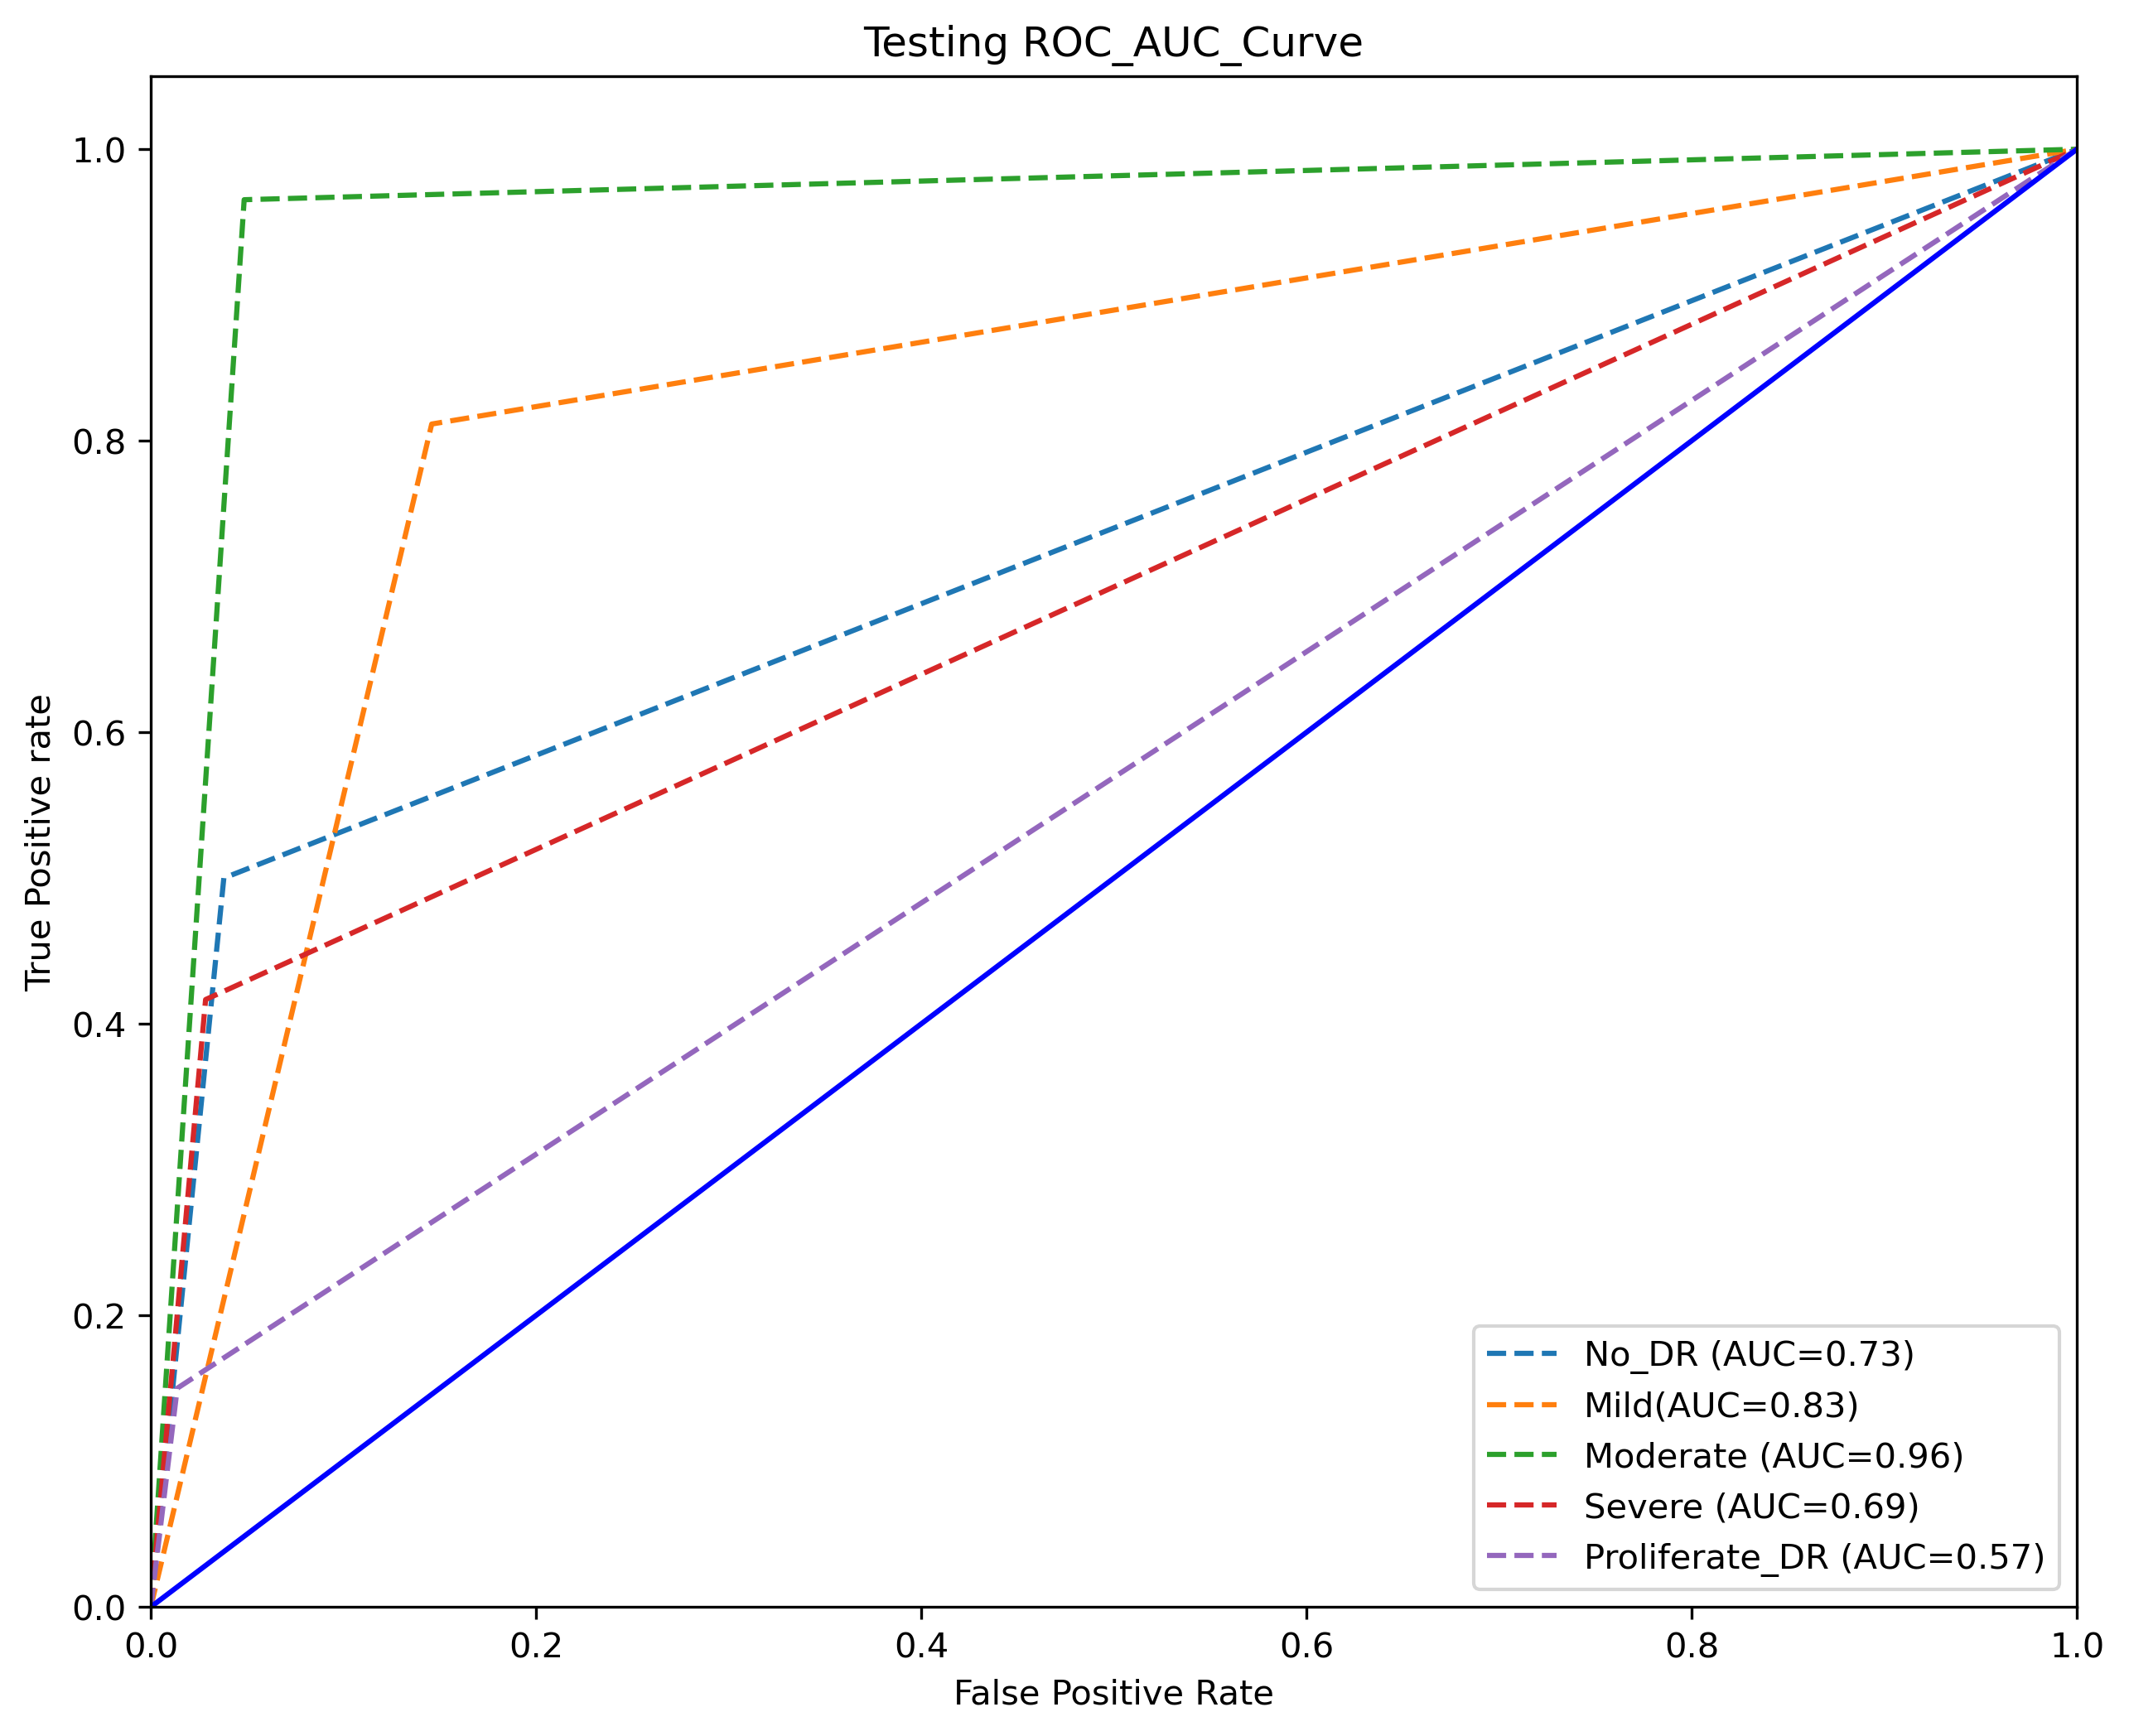

In [44]:
fpr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]

fig=plt.figure(figsize=(10, 8), dpi=300)
for i in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],pred_labels[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='No_DR (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Mild(AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Moderate (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Severe (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==4:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Proliferate_DR (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Testing ROC_AUC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet_testing-79_5.png',dpi=300)# roc curve for classes